## End-of-speech classification

In [1]:
import os # for reading the .json files
import json # for reading the .json files (dialog dataset)
import numpy as np

In [2]:
# from MultiWOZ-Parser; reading the names of the files for training, testing, validation datasets
# https://github.com/jojonki/MultiWOZ-Parser/blob/master/parser.py

def load_json(data_file):
    if os.path.isfile(data_file):
        with open(data_file, 'r') as read_file:
            data = json.load(read_file)
            return data

def load_list_file(list_file):
    with open(list_file, 'r') as read_file:
        dialog_id_list = read_file.readlines()
        dialog_id_list = [l.strip('\n') for l in dialog_id_list]
        return dialog_id_list
    return

In [3]:
dialog_data_file = '../MULTIWOZ/data.json'
dialog_data = load_json(dialog_data_file)
dialog_id_list = list(set(dialog_data.keys()))

valid_list_file = '../MULTIWOZ/valListFile.json'
test_list_file = '../MULTIWOZ/testListFile.json'

valid_id_list = list(set(load_list_file(valid_list_file)))
test_id_list = load_list_file(test_list_file)
train_id_list = [did for did in dialog_id_list if did not in (valid_id_list + test_id_list)]

train_data = [v for k, v in dialog_data.items() if k in train_id_list]
valid_data = [v for k, v in dialog_data.items() if k in valid_id_list]
test_data = [v for k, v in dialog_data.items() if k in test_id_list]

In [4]:
# merging all datasets together
data = train_data + valid_data + test_data

In [5]:
import re # for regex

def text_tokens(text):
    # transforming to lowercase
    text = text.lower()
    # replacing whitespace characters with spaces
    text = re.sub("\\s", " ", text)
    # removing everything that is not a letter
    text = re.sub("[^a-zA-Z ']", "", text)
    
    # splitting string into array based on spaces
    tokens = text.split(' ')
    
    # removing empty strings from the tokens array
    tokens = list(filter(('').__ne__, tokens))
    
    return tokens

In [6]:
# from MultiWOZ-Parser
# https://github.com/jojonki/MultiWOZ-Parser/blob/master/parser.py

def get_dst_diff(prev_d, crnt_d):
    assert len(prev_d) == len(crnt_d)
    diff = {}
    for ((k1, v1), (k2, v2)) in zip(prev_d.items(), crnt_d.items()):
        assert k1 == k2
        if v1 != v2: # updated
            diff[k2] = v2
    return diff

def get_lines(d):
    assert 'log' in d
    assert 'goal' in d
    domains = []
    ignore_keys_in_goal = ['eod', 'messageLen', 'message'] # eod (probably) means the user archieved the goal. 
    for dom_k, dom_v  in d['goal'].items():
        if dom_v and dom_k not in ignore_keys_in_goal: # check whether contains some goal entities
            domains.append(dom_k)
            
    lines = []
    
    prev_d = None
    for i, t in enumerate(d['log']):
        spk = 'Usr' if i % 2 == 0 else 'Sys' # Turn 0 is always a user's turn in this corpus.
        if spk == 'Sys':
            if prev_d is None:
                prev_d = t['metadata']
            else:
                crnt_d = t['metadata']
                dst_diff = get_dst_diff(prev_d, crnt_d)
                prev_d = crnt_d

        lines.append(text_tokens(t['text']))

    return lines

In [7]:
def to_array(data):
    # extracting dialogs from data
    dialogs = [get_lines(dialog) for dialog in data]

    s = []
    # extracting individual dialogs
    for sentences in dialogs:
        # extracting each conversation turn
        for sentence in sentences: 
            s.append(sentence)
        
    return s

In [8]:
# list of individual conversation turns from MultiWOZ dataset
data_full = to_array(data)

In [9]:
from collections import Counter # counting the occurrences of words in the dataset

# creating a vocabulary of top 3000 most frequent words in the dataset
vocab = []
for sentence in data_full:
    for word in sentence:
        vocab.append(word)

VOCAB_SIZE=3000 # constant for the vocabulary size

d = Counter(vocab) # count number of occurrences
q = d.most_common()[0:VOCAB_SIZE] # create vocabulary of VOCAB_SIZE most common words
vocab_top = [q[i][0] for i in range(VOCAB_SIZE)] # extracting the words from Counter structure

---

In [10]:
# From Deep Learning for Text Processing Workshop at Machine Learning Prague 2018
# https://github.com/rossumai/mlprague18-nlp

# Creating dictionary of each word in the pre-trained GloVe embeddings, saving its location indexes 

EMBEDDING_DIM = 50

GLOVE_DIR = "../glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.%dd.txt' % EMBEDDING_DIM))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
# a matrix that is indexed by our vocabulary, containing GloVe embedding for each vocabulary element
embedding_matrix = np.zeros((len(vocab_top) + 1, EMBEDDING_DIM))
for i, word in enumerate(vocab_top):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros; also, [0] is reserved for padding.
        embedding_matrix[i + 1] = embedding_vector

In [12]:
def vocab_indices_vector(tokens):
    vector = [0] * seq_cutoff
    
    for i, t in enumerate(tokens):
        try:
            vector[i] = vocab_top.index(t) + 1 # reserving 0 for padding
        except:
            pass # ignore missing words
        
    return vector

In [13]:
import random

def split_data(data):
    X = []
    Y = []
    for i in range(len(data)):
        if len(data[i]) > 4:
            if (len(data[i]) > 60):
                # too long senteces are cut by default
                X.append(data[i])
                Y.append(0)
            else:
                # first half of the dataset is made out of interrupted conversation turns 
                if (len(data[i]) > 4) and (i <= len(data)//2):
                    # picking random point for splitting the conversation turn
                    l = random.randrange(1, len(data[i]) - 3)
                    # splitting data
                    X.append(data[i][:l])
                    # adding 0 to the target list -> 0 -- interrupted turn 
                    Y.append(0)

                # second half of the dataset is made out of full conversation turns
                else:
                    # adding the full uninterrupted conversation turn
                    X.append(data[i])
                    # adding 1 to the target list -> 1 -- uninterrupted turn 
                    Y.append(1)
            
    # shuffling the dataset
    c = list(zip(X, Y, data))
    random.shuffle(c)
    X, Y, data = zip(*c)
    
    
    # vectorizing the data
    X = [vocab_indices_vector(x) for x in X]
    
    return X,Y,data

In [14]:
lengths = sorted([len(x) for x in data_full]) # sorted lengths of the all reviews
percentile = 0.90 # we are looking at reviews that are short, the 10% making the long reviews
seq_cutoff = lengths[-1]
print(
    'Longest: %d, Average: %f, Median: %d, %d%% percentile: %d tokens' % 
    (lengths[-1], np.mean(lengths), lengths[int(len(lengths)*0.5)], percentile*100, seq_cutoff)
)

Longest: 61, Average: 12.765652, Median: 12, 90% percentile: 61 tokens


In [15]:
# ratio of words not included in the GloVe matrix
1. * np.count_nonzero(np.all(embedding_matrix == 0, axis=1)) / len(vocab)

0.0002371172240746815

In [16]:
X, Y, data_clean = split_data(data_full)

In [17]:
# splitting into training and validating parts
# 2/3 for training, 1/3 for validating
s = (len(X)//3)*2

X_train = X[:s]
Y_train = Y[:s]

X_val = X[s+1:]
Y_val = Y[s+1:]

---

In [18]:
# NN from Deep Learning for Text Processing Workshop at Machine Learning Prague 2018
# https://github.com/rossumai/mlprague18-nlp

from tensorflow.keras.layers import Activation, Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, Dropout
from tensorflow.keras.models import Model
import numpy as np

class GloveCNNAwesomeSentimentModel(object):
    def __init__(self, N=256, size=3):
        self.model = self.create(N, size)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N, size):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab_top) + 1, output_dim=EMBEDDING_DIM,
                                 input_length=seq_cutoff)(seq_indices)
        seq_conv = Conv1D(N, size, activation='relu')(Dropout(0.2)(seq_embedded)) # dropout - 0.2
        max_conv = GlobalMaxPooling1D()(seq_conv)
        hidden_repr = Dense(N, activation='relu')(max_conv)
        sentiment = Dense(1, activation='sigmoid')(Dropout(0.2)(hidden_repr))

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val,EPOCHS=7):
        print('Fitting...')
        return self.model.fit(np.array(X), np.array(y), 
                              validation_data=(np.array(X_val), np.array(y_val)),
                              epochs=EPOCHS, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))

In [19]:
sentiment = GloveCNNAwesomeSentimentModel()
history = sentiment.train(
    X_train, Y_train, X_val, Y_val
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 61)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 61, 50)            150050    
_________________________________________________________________
dropout (Dropout)            (None, 61, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 59, 256)           38656     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [20]:
# test of the network
for i in range(200,210):
    if np.random.uniform() > 0.5:
        if (len(data_clean[i]) > 4):
            # picking random point for splitting the conversation turn
            l = random.randrange(1, len(data_clean[i]) - 3)

            test_tokens = text_tokens(' '.join(str(e) for e in data_clean[i][:l]))
            prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0]

            print(0, prediction, ' '.join(str(e) for e in data_clean[i][:l]))
    else:
        test_tokens = text_tokens(' '.join(str(e) for e in data_clean[i]))
        prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0]

        print(1, prediction, ' '.join(str(e) for e in data_clean[i]))

1 [0.9240405] there are many many restaurants in town is there a certain area of town in which you would be visiting
0 [1.3241993e-06] parkside pools is located in the centre of town would
0 [0.4050427] i want to commute between the hotel and restaurant i need to be
1 [0.87981904] the address is green street city centre
1 [0.8990121] that's okay i'll just pick the first one can you make a reservation for at this monday
1 [0.91263175] yes i need places to go in the east
1 [0.8240322] i have the alexander bed and breakfast that is cheap and university arms hotel that is expensive
0 [2.0475996e-07] ok i have the
1 [0.9958834] you're welcome is there anything else i can do for you
1 [0.04672246] i will leave thursday


In [21]:
# test of the network
sentiment.model.evaluate(X_val[10000:20000], Y_val[10000:20000], verbose=0, batch_size=100)

[0.19022391468286515, 0.9289]

---

## Accuracy based on length

In [22]:
# data - sentences in a vector, data_clean - readable sentences
def LengthInspection(data, data_clean, targets, LENGTH_MIN, LENGTH_MAX):
    extracted = []
    targ = []
    for i in range(len(data)):
        if (len(data_clean[i]) >= LENGTH_MIN) and (len(data_clean[i]) <= LENGTH_MAX):
            extracted.append(data[i])
            targ.append(targets[i])
            
    return extracted, targ

In [23]:
d_set = []
t_set = []
stop = 1

while stop <= 60:
    d, t = LengthInspection(X_val,data_clean[s+1:],Y_val,stop-1,stop)
    d_set.append(d)
    t_set.append(t)
    stop += 1

In [24]:
l_ac = []
l_er = []

# 38 is the length of the longest sentence
for i in range(38):
    er, ac = sentiment.model.evaluate(d_set[i], t_set[i], verbose=0, batch_size=50)
#     print('length interval: (',i,i+1,'), error:',er,', accuracy:',ac)
    l_ac.append(ac)
    l_er.append(er)

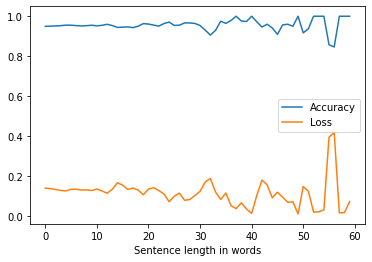

In [48]:
import matplotlib.pyplot as plt

plt.plot(l_ac, label='Accuracy')
plt.plot(l_er, label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()

---

## Different dataset - e2e

In [26]:
import pandas as pd

restaurant_data = pd.read_csv('e2e/restaurant_all.tsv', sep='\t',error_bad_lines=False,warn_bad_lines=False)['Message.Text']
taxi_data = pd.read_csv('e2e/taxi_all.tsv', sep='\t',error_bad_lines=False,warn_bad_lines=False)['Message.Text']
movie_data = pd.read_csv('e2e/movie_all.tsv', sep='\t',error_bad_lines=False,warn_bad_lines=False)['Message.Text']

In [27]:
print(restaurant_data[12])

No I really need Sunday - Does either of the other 2 places have an opening? Like Flatbread Neapolitan Pizzeria and it can be anywhere from 11 am - 2 pm


In [28]:
# X_restuarant, Y_restuarant, data_clean_restuarant = split_data(np.array(restaurant_data['Message.Text'].values))

In [29]:
def e2eGetter(data):
    sentences = []
    for sentence in data:
        if isinstance(sentence, str):
            sentences.append(text_tokens(sentence))
    
    return sentences

In [30]:
r_data = e2eGetter(restaurant_data)
t_data = e2eGetter(taxi_data)
m_data = e2eGetter(movie_data)

e2e_data = r_data + t_data + m_data

In [31]:
e2e_X, e2e_Y, e2e_data_clean = split_data(e2e_data)

In [32]:
# splitting into training and validating parts
# 2/3 for training, 1/3 for validating
e2e_s = (len(e2e_X)//3)*2

e2e_X_train = e2e_X[:e2e_s]
e2e_Y_train = e2e_Y[:e2e_s]
e2e_X_val = e2e_X[e2e_s+1:]
e2e_Y_val = e2e_Y[e2e_s+1:]

In [50]:
sentiment = GloveCNNAwesomeSentimentModel()
history = sentiment.train(
    e2e_X_train, e2e_Y_train, e2e_X_val, e2e_Y_val
)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 61)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 61, 50)            150050    
_________________________________________________________________
dropout_6 (Dropout)          (None, 61, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 59, 256)           38656     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0   

In [51]:
d_set = []
t_set = []
stop = 1

while stop <= 60:
    d, t = LengthInspection(e2e_X_val,e2e_data_clean[e2e_s+1:],e2e_Y_val,stop-1,stop)
    d_set.append(d)
    t_set.append(t)
    stop += 1

In [52]:
l_ac = []
l_er = []

for i in range(60):
    er, ac = sentiment.model.evaluate(d_set[i], t_set[i], verbose=0, batch_size=50)
    l_ac.append(ac)
    l_er.append(er)

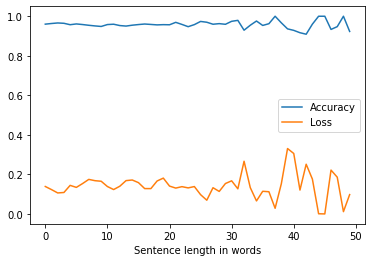

In [53]:
plt.plot(l_ac[:50], label='Accuracy')
plt.plot(l_er[:50], label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()

In [55]:
# test of the network
for i in range(10,50):
    if np.random.uniform() > 0.5:
        if (len(e2e_data_clean[i]) > 4):
            # picking random point for splitting the conversation turn
            l = random.randrange(1, len(e2e_data_clean[i]) - 3)

            test_tokens = text_tokens(' '.join(str(e) for e in e2e_data_clean[i][:l]))
            prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0]

            print(0, prediction, ' '.join(str(e) for e in e2e_data_clean[i][:l]))
    else:
        test_tokens = text_tokens(' '.join(str(e) for e in e2e_data_clean[i]))
        prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0]

        print(1, prediction, ' '.join(str(e) for e in e2e_data_clean[i]))

0 [8.14488e-06] what
1 [0.31402963] 
0 [1.0221998e-05] your reservation
1 [0.99983823] i need a ride to lowe's or home depot or one of those types of stores i'm at anderson elementary in bondurant and we have a major plumbing leak going on asap please just one person
1 [0.0003689] thanks
1 [0.00078598] yes please
1 [0.00078598] yes please
1 [0.9995584] the pick up location will be columbus ohio polaris pkwy with just person
1 [0.00184472] your reservation at wild ginger asian restaurant for pm for people under joe does has been confirmed
1 [0.99932766] great that's all the information i need please let me know which of the following options you'd like to reserve uberx uberxl pedal uberselect uberblack ubersuv for hire
0 [0.31402963] san
1 [0.98344916] you're welcome have a nice day and thank you for using our service
1 [1.7747319e-06] enjoy your meal this has been booked
1 [0.02506169] the nearest burger king
1 [0.99997485] what is the pickup location
1 [0.01669415] what time and date 

---

## Different dataset - taskmaster

In [58]:
def taskmasterGetter(path):
    collection = []
    f = open(path, 'r')
    for x in f:
        if '"text":' in x:
            collection.append(text_tokens(x.lstrip()[len('"text": '):]))
            
    return collection

In [59]:
taskmaster = taskmasterGetter('taskmaster/flights.json') +\
             taskmasterGetter('taskmaster/food-ordering.json') +\
             taskmasterGetter('taskmaster/hotels.json') +\
             taskmasterGetter('taskmaster/movies.json') +\
             taskmasterGetter('taskmaster/music.json') +\
             taskmasterGetter('taskmaster/restaurant-search.json') +\
             taskmasterGetter('taskmaster/sports.json')

In [60]:
tm_X, tm_Y, tm_data_clean = split_data(taskmaster)

In [61]:
# splitting into training and validating parts
# 2/3 for training, 1/3 for validating
tm_s = (len(tm_X)//3)*2

tm_X_train = tm_X[:tm_s]
tm_Y_train = tm_Y[:tm_s]
tm_X_val = tm_X[tm_s+1:]
tm_Y_val = tm_Y[tm_s+1:]

In [62]:
print(len(tm_Y_val),
      len(np.array(tm_Y_val)[np.array(tm_Y_val) == 0]),
      len(np.array(tm_Y_val)[np.array(tm_Y_val) == 1]))

83580 40204 43376


In [63]:
sentiment = GloveCNNAwesomeSentimentModel()
history = sentiment.train(
    tm_X_train, tm_Y_train, tm_X_val, tm_Y_val, EPOCHS=7)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 61)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 61, 50)            150050    
_________________________________________________________________
dropout_8 (Dropout)          (None, 61, 50)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 59, 256)           38656     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0   

In [64]:
d_set = []
t_set = []
stop = 1

while stop <= 60:
    d, t = LengthInspection(tm_X_val,tm_data_clean[tm_s+1:],tm_Y_val,stop-1,stop)
    d_set.append(d)
    t_set.append(t)
    stop += 1

In [65]:
l_ac = []
l_er = []

for i in range(60):
    er, ac = sentiment.model.evaluate(d_set[i], t_set[i], verbose=0, batch_size=50)
    l_ac.append(ac)
    l_er.append(er)

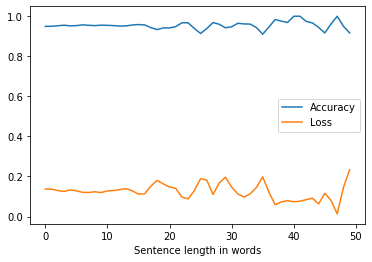

In [66]:
plt.plot(l_ac[:50], label='Accuracy')
plt.plot(l_er[:50], label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()

In [68]:
# test of the network
for i in range(100,200):
    if np.random.uniform() > 0.5:
        if (len(tm_data_clean[i]) > 4):
            # picking random point for splitting the conversation turn
            l = random.randrange(1, len(tm_data_clean[i]) - 3)

            test_tokens = text_tokens(' '.join(str(e) for e in tm_data_clean[i][:l]))
            prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0]

            print(0, prediction, ' '.join(str(e) for e in tm_data_clean[i][:l]))
    else:
        test_tokens = text_tokens(' '.join(str(e) for e in tm_data_clean[i]))
        prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0]

        print(1, prediction, ' '.join(str(e) for e in tm_data_clean[i]))

1 [0.5094632] two layovers or less
0 [7.782923e-06] i
1 [0.073711] ocracoke
1 [0.00118369] pm
1 [3.3294207e-05] days from tomorrow
1 [0.00010891] alright goodbye
1 [3.0075606e-05] alright
1 [0.31146222] airport shuttle service
1 [5.5181707e-05] okay
0 [0.00076962] i'm going to order six hot dogs total for three people and i would like the first
1 [0.9933796] what else can you tell me
0 [6.973094e-06] i can help
0 [0.00185425] hold
1 [0.02110464] okay so i'll find a hotel for you that has free wifi and a restaurant near to the hotel and i also found over two dozen hotels for you with those amenities would you like me to list the top for you by price or by rating
0 [0.01056679] not too early in the morning
1 [0.25846925] and i'll be leavingua on april th
1 [3.66059e-08] yep
0 [0.00078996] excellent i've got those details now tell me more about what you're
0 [0.00017743] this
1 [0.96980774] overlooks the mississippi river
1 [0.04651928] okaywhat else
1 [0.073711] studios
0 [0.6024974] oka